# Assignment 3 || Image Classification & Object Recognition
Muhammad Maulud Hidayatullah Rambe || 1301154166

### Setup Sistem

Sebelum melakukan proses pengenalan sistem, berikut adalah inisiasi awal yang dilakukan untuk mengimport package yang digunakan serta variabel konstan.

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import cv2
import os
import h5py
import glob
import warnings
warnings.filterwarnings('ignore')

# Untuk membuat ukuran gambar konsisten
fixed_image_size = tuple((256, 256))

# Lokasi file
train_path = "dataset/train"
test_path = "dataset/test"

# Nama-nama label yang akan digunakan
train_labels = os.listdir(train_path)

# List kosong untuk fitur citra
color_features = []
shape_features = []
combined_features = []
labels = []

---
### Descriptor

Pada pembuatan sistem pengenalan ini akan digunakan 2 descriptor, yaitu:

#### 1. Descriptor Warna
Descriptor warna yang digunakan adalah menggunakan _color histogram_.

In [2]:
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

#### 2. Descriptor Bentuk
Descriptor bentuk yang digunakan adalah menggunakan _hu moments_.

In [3]:
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

---
### Dataset

Pada pembuatan sistem pengenalan buah ini, digunakan dataset yang diberikan yaitu dataset buah _rgb_ dengan beberapa folder buah didalamnya. Buah-buahan yang terdapat didalamnya yaitu: _apple_, _banana_, _lemon_, _lime_, _orange_, _peach_, _pear_. Jumlah gambar keseluruhan adalah sebanyak 21.285 citra gambar.

Dilakukan juga perubaha struktur direktori agar sistem lebih dinamis dan bisa dikembangkan lagi nantinya. Berikut adalah bentuk struktur direktori dataset:

In [ ]:
|--image-classification (folder)
|--|--dataset (folder)
|--|--|--train (folder)
|--|--|--|--apple (folder)
|--|--|--|--|--image_1.jpg
|--|--|--|--|--image_2.jpg
|--|--|--|--|--...
|--|--|--|--banana (folder)
|--|--|--|--|--image_1.jpg
|--|--|--|--|--image_2.jpg
|--|--|--|--|--...
|--|--|--|--lemon (folder)
|--|--|--|--|--image_1.jpg
|--|--|--|--|--image_2.jpg
|--|--|--|--|--...
|--|--|--|--... (folder)
|--|--|--test (folder)
|--|--|--|--image_1.jpg
|--|--|--|--image_2.jpg

---
### Deskripsi Sistem
Berikut adalah blok diagram dari sistem yang akan dibangun.
![Blok Diagram dari Sistem](blok_diagram.jpg)

#### Penjelasan
Pertama akan dilakukan input data. Kemudian dilakukan ekstraksi ciri dari data gambar yang diinputkan. Pada proses ekstraksi akan dilakukan _preprocessing_ yang terjadi didalam fungsi descriptor. Setelah melakukan ekstraksi ciri, selanjutnya adalah membagi dataset menjadi dua bagian, yaitu data training sebesar 2/3 dan data testing sebesar 1/3. Setelah itu, dilakukan klasifikasi, kemudian pengujian dengan data testing.

---
### Ekstraksi Ciri
Proses ekstraksi ciri dilakukan untuk tiap jenis percobaan sistem yang dilakukan. Ekstraksi dibagi berdasarkan penggunaan descriptor.
1. Ekstraksi ciri hanya dengan descriptor warna
2. Ekstraksi ciri hanya dengan descriptor bentuk
3. Ekstraksi ciri dengan menggabungkan kedua descriptor

In [4]:
%%time
total_image = 0
for training_name in train_labels:
    dir = train_path + '/' + training_name    
    image_paths = os.listdir(dir)    
    current_label = training_name
    image_count = 0
    
    for image_path in image_paths:
        file = dir + '/' + image_path
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_image_size)

        color_feature = fd_histogram(image)
        shape_feature = fd_hu_moments(image)
        
        combined_feature = np.hstack([color_feature, shape_feature])

        labels.append(current_label)
        color_features.append(color_feature)
        shape_features.append(shape_feature)
        combined_features.append(combined_feature)
        image_count += 1
        
        

    print("[STATUS] Direktori: {}, selesai diproses".format(current_label))
    print("Jumlah gambar: ", image_count)
    total_image += image_count

print ("[STATUS] Feature Extraction selesai...")
print("Jumlah gambar keseluruhan: ", total_image)

[STATUS] Direktori: apple, selesai diproses
Jumlah gambar:  3096
[STATUS] Direktori: banana, selesai diproses
Jumlah gambar:  2826
[STATUS] Direktori: lemon, selesai diproses
Jumlah gambar:  3747
[STATUS] Direktori: lime, selesai diproses
Jumlah gambar:  2514
[STATUS] Direktori: orange, selesai diproses
Jumlah gambar:  2834
[STATUS] Direktori: peach, selesai diproses
Jumlah gambar:  2082
[STATUS] Direktori: pear, selesai diproses
Jumlah gambar:  4186
[STATUS] Feature Extraction selesai...
Jumlah gambar keseluruhan:  21285
Wall time: 1min 18s


kemudian dilakukan perubahan bentuk nilai dari tiap label menjadi nilai nominal. (__apple__ = 1, __banana__ = 2, ...)

In [5]:
targetNames = np.unique(labels)
le = LabelEncoder()
labels_val = le.fit_transform(labels)

---
### Algoritma Machine Learning
Pada sistem ini digunakan algortima K-Nearest Neighgboor untuk proses klasifikasi.

---
### Proses Split Training - Testing & Klasifikasi
Pada tahapan ini, dilakukan proses split data menjadi data train dan data test untuk 3 jenis percobaan. Pada tiap percobaan juga akan dilakukan klasifikasi dan akan mendapatkan hasil akurasi dari tiap percobaan.

#### Menggunakan Descriptor Warna
Berikut adalah proses split training - testing dari percobaan dengan descriptor warna.

In [6]:
test_size = 0.30
seed = 9

(x_train, x_test, y_train, y_test) = train_test_split(color_features,
                                                      labels_val,
                                                      test_size=test_size,
                                                      random_state=seed)

Kemudian, berikut adalah proses klasifikasi dengan menggunakan algoritma kNN.

In [7]:
%%time

num_trees = 100

clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=11)
# clf = RandomForestClassifier(n_estimators=num_trees, random_state=9)
clf.fit(x_train, y_train)

Wall time: 1.23 s


In [8]:
pred = clf.predict(x_test)

Kemudian dilakukan proses perhitungan akurasi dari klasifikasi.

In [9]:
print(accuracy_score(y_test, pred)*100,'%')

99.98434074538052 %


#### Menggunakan Descriptor Bentuk
Berikut adalah proses split training - testing dari percobaan dengan descriptor bentuk.

In [10]:
test_size = 0.30
seed = 9

(x_train, x_test, y_train, y_test) = train_test_split(shape_features,
                                                      labels_val,
                                                      test_size=test_size,
                                                      random_state=seed)

Kemudian, berikut adalah proses klasifikasi dengan menggunakan algoritma kNN.

In [11]:
%%time

num_trees = 100

clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=11)
# clf = RandomForestClassifier(n_estimators=num_trees, random_state=9)
clf.fit(x_train, y_train)

Wall time: 60.8 ms


In [12]:
pred = clf.predict(x_test)

Kemudian dilakukan proses perhitungan akurasi dari klasifikasi.

In [13]:
print(accuracy_score(y_test, pred)*100,'%')

44.4096461008456 %


#### Menggunakan Descriptor Gabungan
Berikut adalah proses split training - testing dari percobaan dengan descriptor gabungan bentuk dan warna. Sebelum itu dilakukan normalisasi pada bagian fitur gabungan.

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
combined_features = scaler.fit_transform(combined_features)

In [15]:
test_size = 0.30
seed = 9

(x_train, x_test, y_train, y_test) = train_test_split(np.array(combined_features),
                                                      labels_val,
                                                      test_size=test_size,
                                                      random_state=seed)

Kemudian, berikut adalah proses klasifikasi dengan menggunakan algoritma kNN.

In [16]:
%%time

num_trees = 100

clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=11)
# clf = RandomForestClassifier(n_estimators=num_trees, random_state=9)
clf.fit(x_train, y_train)

Wall time: 935 ms


In [17]:
pred = clf.predict(x_test)

Kemudian dilakukan proses perhitungan akurasi dari klasifikasi.

In [18]:
print(accuracy_score(y_test, pred)*100,'%')

99.98434074538052 %


---
### Pengujian Data Testing
Berikut adalah pengujian dengan 3 data testing dengan menggunakan hasil dari descriptor gabungan.

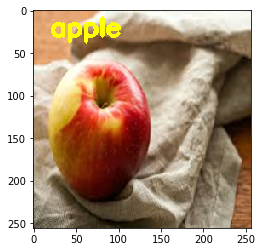

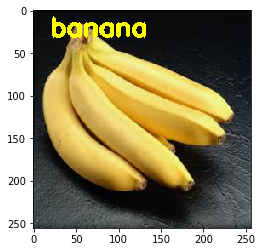

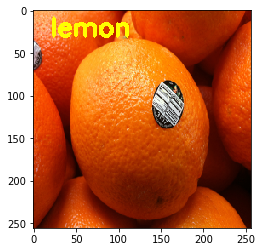

In [19]:
for test_image in os.listdir(test_path):
    file = test_path + '/' + test_image
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_image_size)

    fv_hu_moments = fd_hu_moments(image)
    fv_histogram  = fd_histogram(image)

    combined_feature = np.hstack([fv_histogram, fv_hu_moments])

    prediction = clf.predict(combined_feature.reshape(1,-1))[0]

    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()